In [5]:
#get notebook runtime
from timeit import default_timer as timer
start = timer()

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Data Transformation
import pandas as pd
import geopandas as gpd
import numpy as np
import h3
import shapely
import math


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx


# ML Processing
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

# Neural Networks
from tensorflow import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

## Data Readin and Helper Functions

In [9]:
# Main Taxi Trip Data
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")
#df = df.sample(10000)

df["PU_isWorkday"]=df["PU_isWorkday"].astype(int) #convert boolean to int for prediction

# a map that outlines the city of chicago
chicago = gpd.read_file("../data/chicago.geojson")

# Data containing Points of Interest
df_poi = pd.read_csv("../data/POI_per_H3.csv")

# Weather Data, pretransformed to be usable for prediction
weather_df = pd.read_parquet("../data/weather_transformed_22_08_2021.parquet")
weather_df["hour"] = weather_df["datetime"].dt.hour+1
weather_df["has_precipitation"] = weather_df["has_precipitation"].astype(int)
weather_df.drop(columns=["month","datetime"],inplace=True)

In [10]:
#https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
def eval_reg(y_test,y_pred,title=False):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].scatter(y_pred, y_test, edgecolors=(0, 0, 1),alpha=0.1)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    ax[1].hist(y_pred-y_test,bins=100)

    if title:
        fig.suptitle(title)
        
    plt.show()
    
    # model evaluation for testing set
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    max_error = sklearn.metrics.max_error(y_test, y_pred)#Calculating Max_Error

    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print('Max error is {}'.format(max_error))
    
    return [mae, r2]

### Characteristics

Let's recall the characteristics of our dataset:

In [11]:
df.shape

(1089891, 43)

In [12]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,12,1,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,15,1,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,8,1,March,Friday,9,2017-03-03,3,4,8,True
14574858,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,11,0,July,Sunday,30,2017-07-23,7,6,11,False
3642582,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,11,0,February,Saturday,8,2017-02-25,2,5,11,False


In [13]:
df.isnull().sum()

Trip ID                            0
Taxi ID                          401
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Census Tract           328349
Dropoff Census Tract          331418
Pickup Community Area          78095
Dropoff Community Area         98584
Fare                               0
Tips                               0
Tolls                         284734
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude       78095
Pickup Centroid Longitude      78095
Dropoff Centroid Latitude      98584
Dropoff Centroid Longitude     98584
PU_H3                          78095
DO_H3                          98584
PU_DISTANCE_CITY               78095
DO_DISTANCE_CITY               98584
DURATION_IN_MINUTES                0
MPH                                0
P

To get an overview of the data this figure checks correlations between all variables. While some Variables show strong correlations, others aren’t correlated at all. However, most correlations seem quite obvious. Timewise: longer rides are also longer in distance, are associated with higher trip fares as well as tips. The negative correlation of the length of ride and Pick-up longitude hints at the fact that rides in the south of Chicago tend to be longer. This seems to be in line with the fact that the city center is in the north of the urban area of Chicago, so many customers might take the taxi ride towards the city center. 

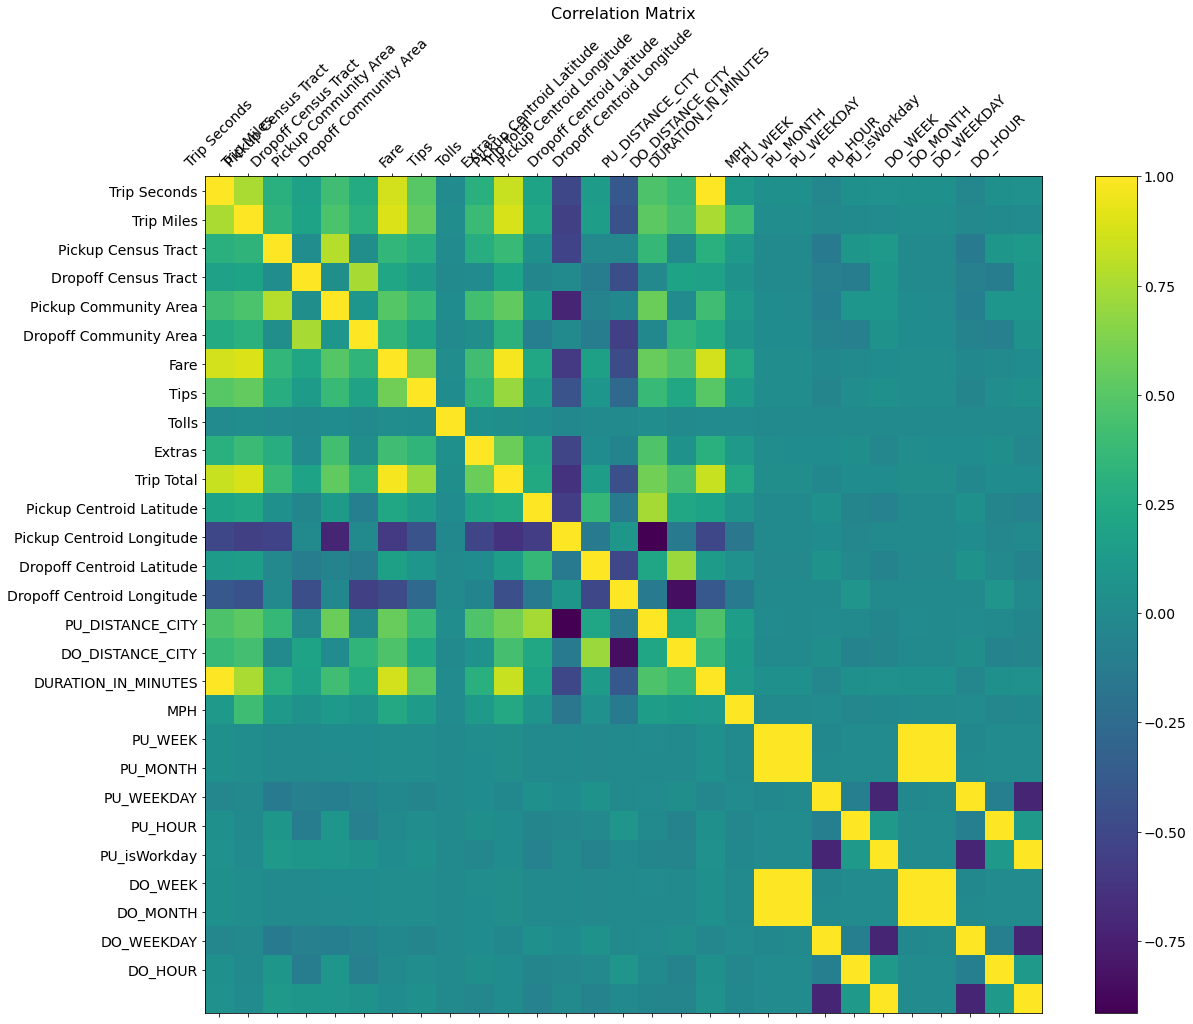

In [16]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following figure shows the goalvariable „taxi rides“ per hour separately for every weekday. Interestingly one can clearly see that on weekends there are much more taxi rides between 23h at night and 5h in the morning compared to during the week. We suspect these rides to serve customers going out and coming back from nightlife. Whereas Weekdays have a higher ride frequency during regular working hours between 9h to 20h commuting forth and back from work. 

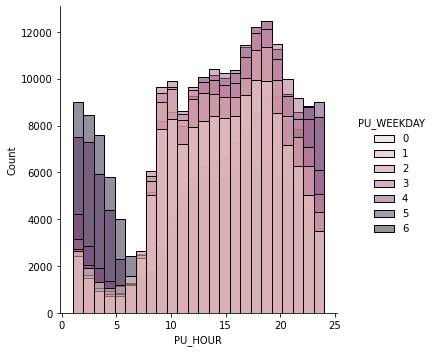

In [17]:
sns.displot(df,x='PU_HOUR', hue='PU_WEEKDAY', bins=24)


# 0. Data Preparation

The purpose of this part of the project is to build advanced models that can predict taxi demand in a certain area at a certain time frame. Consistent with the rest of the project, we use H3 coding for spatial segmentation. To get a feeling for the useful spatial resolutions that H3 offers, we start by plotting a map of chicago filled with different sized H3s to choose the relevant ones. We start with Level 9, as the data from our preprocessing (see Notebook Data Cleaning) is on Level 9, and then decrease the resolution.

The list below (taken from https://h3geo.org/docs/core-library/restable/) gives an impression of how big the hexagons in the respective resolution are.
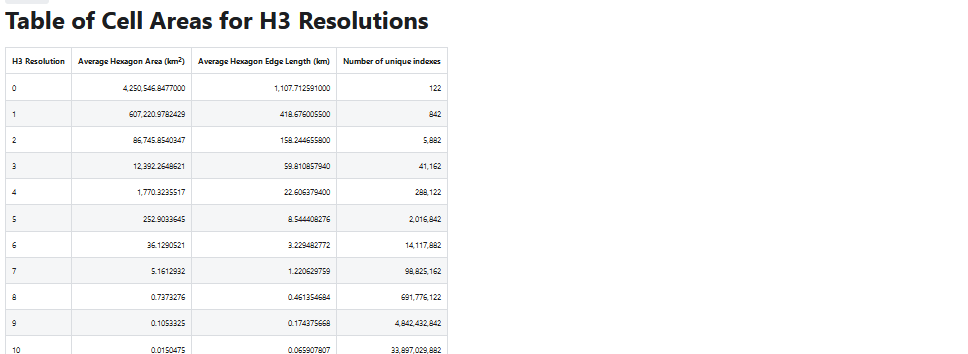

In [18]:
# set Chicago city borders
chicago_fence=chicago.geometry[0][1]

# function to get all H3 within the Chicago city borders:

def get_chicago_gdf_h3(chicago_geojson,h3_res):
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id','geometry','h3_centroid'])


    # Iterate over every row of the geo dataframe
    for _,row in chicago.iterrows():  
        # Parse out info from columns of row
        district_multipolygon = row.geometry

        # Convert multi-polygon into list of polygons
        district_polygon = list(district_multipolygon)

        for polygon in district_polygon:
            # Convert Polygon to GeoJSON dictionary
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            # Parse out geometry key from GeoJSON dictionary
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            # Fill the dictionary with H3_hexagons
            h3_hexes = h3.polyfill_geojson(poly_geojson, h3_res) 
            for h3_hex in h3_hexes:
                h3_geo_boundary = shapely.geometry.Polygon(
                    h3.h3_to_geo_boundary(h3_hex,geo_json=True)
                )
                h3_centroid = h3.h3_to_geo(h3_hex)
                # Append results to dataframe
                h3_df.loc[len(h3_df)]=[
                    h3_hex,
                    h3_geo_boundary,
                    h3_centroid
                ]
    return h3_df

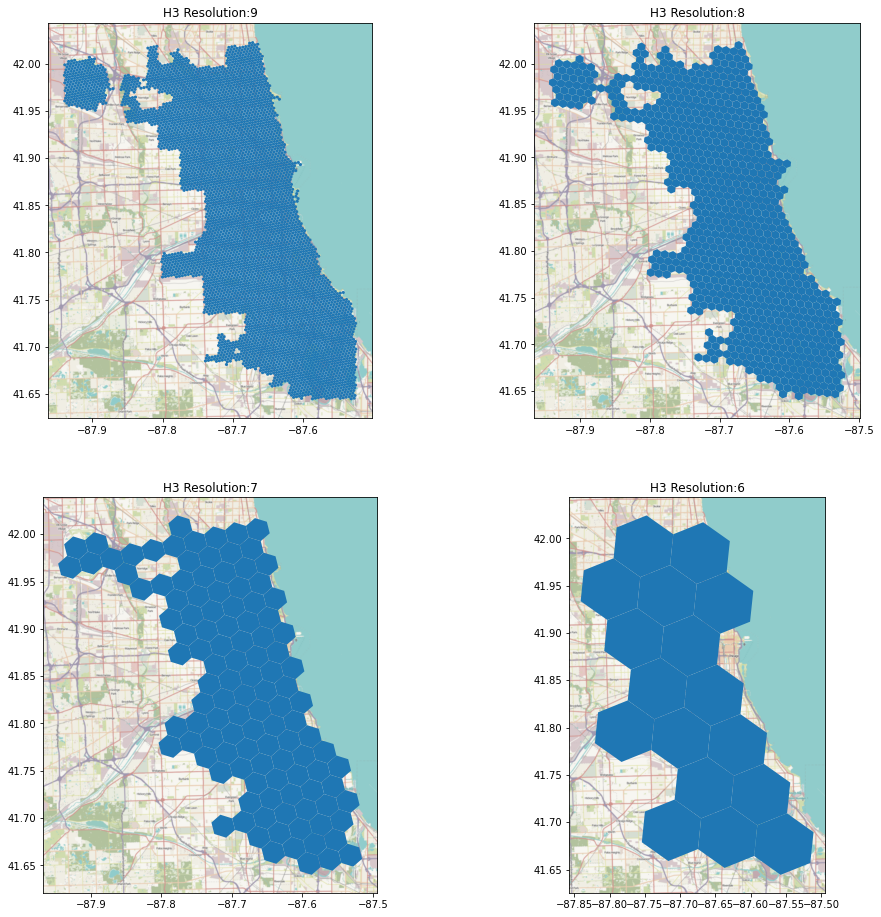

In [19]:
fig,axes=plt.subplots(2,2,figsize=(16,16))

h3_level = 9
for row in axes:
    for ax in row:
        h3_gdf = gpd.GeoDataFrame(get_chicago_gdf_h3(chicago, h3_level))
        h3_gdf.plot(ax=ax)
        ax.set_title("H3 Resolution:"+str(h3_level))
        ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
        chicago.plot(ax=ax,alpha=0) #scaling
        
        h3_level-=1

Predicting daily or hourly taxi demand for resolution 9 seems to be a little too detailed, while resolution 6 seems not detailed enough, so we focus on predicting on resolutions 7 and 8.

In terms of temporal resolutions, we find most interesting would be either daily, hourly, or 6-hourly.

### Preparing data for our chosen resolutions
To efficiently design our models for different resolutions and with different feature sets, we set up a reuseable function that builds a prediction dataframe for the desired temporal and spatial resolution. We add options to add dummy variables for 
* weather_description (~40 weather descriptions on hourly basis), 
* POI categories (~50 different categories of POI and their count in the specific H3), 
* H3 (Dummy Variable that can catch variance that is explained by only the predicted H3 polygon)

To obtain robust values for the predictors, we use the median.

In [20]:
# Function to construct the prediction data set:

def get_data(df,weather_df,df_poi,temp_resolution,spatial_resolution=False,dummy_poi_category=False,dummy_weather=False,dummy_h3=False):
    #Filter out all Data that doesn't have Pickup Location Data
    dff = df.copy()[df["PU_H3"].isnull()!=True]
    
    
    #---- Calculate new H3 based on specified resolution (if it is higher than resolution in dataset) -----#
    h3_base_resolution = h3.h3_get_resolution(dff["PU_H3"].iloc[0]) #get original resolution in data
    
    if h3_base_resolution<spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in dataset. Keeping data on resolution",h3_base_resolution)
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if h3_base_resolution == spatial_resolution:
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if spatial_resolution and spatial_resolution<h3_base_resolution:
        #calculate new H3s with centroids of old H3s
        dff["PU_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],spatial_resolution),axis=1)
        dff["DO_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],spatial_resolution),axis=1)
        
    
    dff_h3 = dff.groupby(["PU_H3_pred",
                               "PU_DATE",
                               "PU_HOUR"]).agg(H3_index=("PU_H3_pred","first"),
                                               DATE_index=("PU_DATE","first"),
                                               HOUR_index=("PU_HOUR","first"),
                                               count=("PU_H3","count"),
                                               MONTH=("PU_MONTH","first"),
                                               DISTANCE_CITY=("PU_DISTANCE_CITY","median"),
                                               WEEKDAY=("PU_WEEKDAY","first"),
                                               isWorkday=("PU_isWorkday","first"))
    
    dff_h3 = pd.merge(dff_h3,weather_df,left_on=["DATE_index","HOUR_index"],right_on=["date","hour"],how="left")
        
        
    #--------------------------- Slice Hours of Days into set Temporal Resolution ---------------------------#
    # This slices the day into equal parts. Input is the amount of slices per day.
    # temp_resolution = 24 would produce hourly data,
    # temp_resolution = 6 would produce 4-hourly data,
    # temp_resolution = 1 would produce daily data,
    slicer = 24 / temp_resolution
    dff_h3["PU_HOUR_slice"] = np.ceil(dff_h3["HOUR_index"]/slicer).astype(int)
    
    
    dff_grouped = dff_h3.groupby(["H3_index",
                                   "DATE_index",
                                   "PU_HOUR_slice"]).agg(H3=("H3_index","first"),
                                                         DATE=("DATE_index","first"),
                                                         HOUR_slice=("PU_HOUR_slice","first"),
                                                         count=("count","sum"),#sums over all hours in slice
                                                         MONTH=("MONTH","first"),
                                                         DISTANCE_CITY=("DISTANCE_CITY","median"),
                                                         WEEKDAY=("WEEKDAY","first"),
                                                         isWorkday=("isWorkday","first"),
                                                         Temperature=("Temperature","median"),
                                                         Humidity=("Humidity","median"),
                                                         Wspeed=("Wind Speed","median"),
                                                         has_precipitation = ("has_precipitation","sum"),
                                                         precipitation_intensity_median=("precipitation_intensity","median"))




    #------------------------- Weather Description Dummies ----------------------#
    if dummy_weather:
        dff_grouped=dff_grouped.drop(columns=["has_precipitation","precipitation_intensity"])
        weather_df_dummies = weather_df.copy()[["date","hour","weather_description"]]
        weather_df_dummies = pd.concat([weather_df_dummies,
                                        pd.get_dummies(weather_df["weather_description"])],
                                       axis=1)
        weather_df_dummies["hour_slice"] = np.ceil(weather_df_dummies["hour"]/slicer).astype(int)
        weather_df_dummies = weather_df_dummies.drop(columns=["weather_description","hour"])

        weather_df_dummies = weather_df_dummies.groupby(["date","hour_slice"]).sum()
        dff_grouped=pd.merge(left=dff_grouped,
                             right=weather_df_dummies,
                             left_on=["DATE","HOUR_slice"],
                             right_index=True,
                             how="left")
        
        
        
    #---------------------------------------- POI ----------------------------------------#
    #get poi to right resolution
    
    dff_poi = df_poi.copy()
    dff_poi["area"]= dff_poi.apply(lambda x: h3.geo_to_h3(x["lng"],x["lat"],spatial_resolution),axis=1)
    if dummy_poi_category:
        dff_poi = dff_poi.drop(columns=["osm_id","feature","lat","lng","intersection"])
        dff_poi_index = dff_poi["area"]
        dff_poi = pd.get_dummies(dff_poi["key"])
        dff_poi.index = dff_poi_index
        dff_poi = dff_poi.groupby("area").sum().astype(int)
    else:
        dff_poi = dff_poi.groupby("area").agg(poi_count=("area","count"))
    
        
    dff_grouped=pd.merge(dff_grouped,dff_poi,left_on="H3",right_on="area",how="left")
    

    #----------------------------------- H3 Dummies --------------------------------------#

    
    if dummy_h3:
        h3_dummies = pd.get_dummies(dff_grouped["H3"])
        dff_grouped = pd.concat([dff_grouped,
                                 h3_dummies],axis=1)

    
    
    #----------------------------------- Output ------------------------------------#
    dff_grouped = dff_grouped.drop(columns=["H3","DATE"])
    dff_grouped=dff_grouped.replace(np.nan,0)
    return dff_grouped


## Benchmark: Simple Decision Tree and Linear Regressions
To get a benchmark, we set up simple Decision Tree and Linear Regressions as Benchmarks for our more complex, advanced Neural Networks and SVM Regressors. We use a reduced feature set without dummy variables in order to reduce model complexity, as these are just simple benchmark models.

In [21]:
df_pred_simple = get_data(df,weather_df,df_poi,6,8)

#Split off dependant and independant variable
y=df_pred_simple["count"]
X=df_pred_simple.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
# scaler uses the formula: z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False,
# and s is the standard deviation of the training samples or one if with_std=False.

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [22]:
df_pred_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239218 entries, 0 to 239217
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   HOUR_slice                      239218 non-null  int32  
 1   count                           239218 non-null  int64  
 2   MONTH                           239218 non-null  int64  
 3   DISTANCE_CITY                   239218 non-null  float64
 4   WEEKDAY                         239218 non-null  int64  
 5   isWorkday                       239218 non-null  int32  
 6   Temperature                     239218 non-null  float64
 7   Humidity                        239218 non-null  float64
 8   Wspeed                          239218 non-null  float64
 9   has_precipitation               239218 non-null  float64
 10  precipitation_intensity_median  239218 non-null  float64
 11  poi_count                       239218 non-null  float64
dtypes: float64(7), i

In [23]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

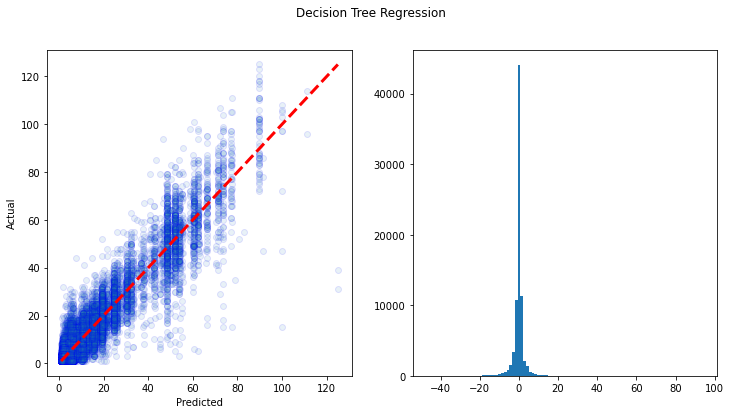

The model performance for testing set
--------------------------------------
MAE is 1.3904646924240691
MSE is 9.187911852134905
RMSE is 3.0311568504673105
R2 score is 0.8964436695788706
Max error is 94.0


[1.3904646924240691, 0.8964436695788706]

In [24]:
tree=DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_s,y_train)
y_pred=tree.predict(X_test_s)

eval_reg(y_test,y_pred,"Decision Tree Regression")

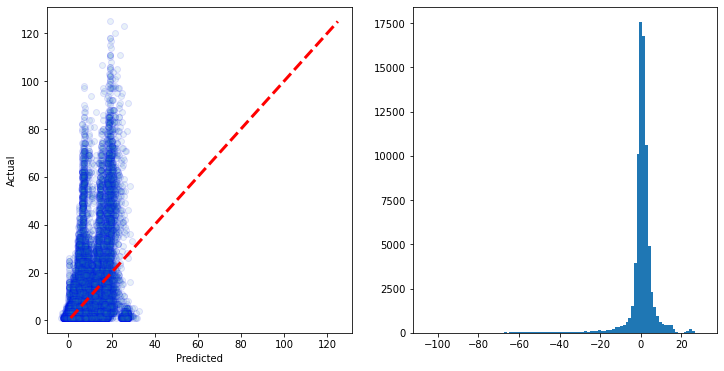

The model performance for testing set
--------------------------------------
MAE is 3.731172619036083
MSE is 65.42575865194465
RMSE is 8.088619081891832
R2 score is 0.26259071810320533
Max error is 105.65192129532633


[3.731172619036083, 0.26259071810320533]

In [25]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_s,y_train)
y_pred=lasso.predict(X_test_s)

eval_reg(y_test,y_pred)

# 1. Neural Networks
Our Dataset for Neural Network Models contains all dummy variables, as Neural Networks are able to cope with a large input space and extract features on their own.

In [26]:
df_pred_ann = get_data(df,weather_df,df_poi,4,8,dummy_poi_category=True,dummy_weather=False,dummy_h3=True)

#Split off dependant and independant variable
y=df_pred_ann["count"]
X=df_pred_ann.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [27]:
def build_reg_nn(layers,input_shape,activation="relu",dropout=False,optimizer="adam"):
    
    model = Sequential()
    model.add(keras.Input(shape=input_shape)) #Input Layer
    
    for layer in layers: # Hidden Layers
        model.add(Dense(layer, activation=activation)) #Add Hidden Layer with specified width and activation funciton
        if dropout: #if wanted, add dropout layer with given factor
            model.add(Dropout(dropout))
  

    model.add(Dense(1,activation="relu")) #Regression Output Layer - everything below 0 doesn't make sense here

    model.compile(loss='mse',
                  metrics=[metrics.RootMeanSquaredError()],
                  optimizer=optimizer)
    
    return model

### Basic Neural Network

Epoch 1/30
8280/8280 [==============================] - 5s 625us/step - loss: 33.6327 - root_mean_squared_error: 5.7994
Epoch 2/30
8280/8280 [==============================] - 6s 682us/step - loss: 18.9771 - root_mean_squared_error: 4.3563
Epoch 3/30
8280/8280 [==============================] - 6s 709us/step - loss: 16.9175 - root_mean_squared_error: 4.1131
Epoch 4/30
8280/8280 [==============================] - 6s 730us/step - loss: 15.4948 - root_mean_squared_error: 3.9363
Epoch 5/30
8280/8280 [==============================] - 6s 733us/step - loss: 15.0033 - root_mean_squared_error: 3.8734
Epoch 6/30
8280/8280 [==============================] - 6s 746us/step - loss: 14.3535 - root_mean_squared_error: 3.7886
Epoch 7/30
8280/8280 [==============================] - 6s 759us/step - loss: 13.9716 - root_mean_squared_error: 3.7379
Epoch 8/30
8280/8280 [==============================] - 6s 752us/step - loss: 13.4028 - root_mean_squared_error: 3.6610
Epoch 9/30
8280/8280 [==================

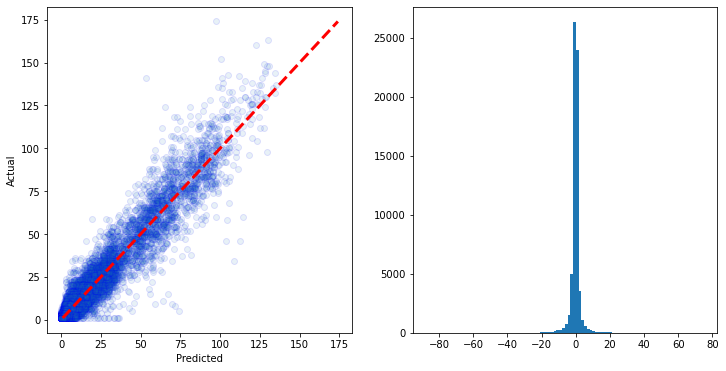

The model performance for testing set
--------------------------------------
MAE is 1.5766185352152422
MSE is 10.56636581838719
RMSE is 3.2505946868822617
R2 score is 0.9313495084384706
Max error is 87.34712600708008


[1.5766185352152422, 0.9313495084384706]

In [28]:
#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try increasing the Network Depth (adding 1 hidden layer)

Epoch 1/30
8280/8280 [==============================] - 9s 1ms/step - loss: 30.6740 - root_mean_squared_error: 5.5384
Epoch 2/30
8280/8280 [==============================] - 8s 981us/step - loss: 17.7816 - root_mean_squared_error: 4.2168
Epoch 3/30
8280/8280 [==============================] - 8s 917us/step - loss: 15.0356 - root_mean_squared_error: 3.8776
Epoch 4/30
8280/8280 [==============================] - 7s 888us/step - loss: 13.9432 - root_mean_squared_error: 3.7341
Epoch 5/30
8280/8280 [==============================] - 8s 1000us/step - loss: 13.2460 - root_mean_squared_error: 3.6395
Epoch 6/30
8280/8280 [==============================] - 8s 958us/step - loss: 12.8235 - root_mean_squared_error: 3.5810
Epoch 7/30
8280/8280 [==============================] - 9s 1ms/step - loss: 12.5572 - root_mean_squared_error: 3.5436
Epoch 8/30
8280/8280 [==============================] - 10s 1ms/step - loss: 12.1231 - root_mean_squared_error: 3.4818
Epoch 9/30
8280/8280 [======================

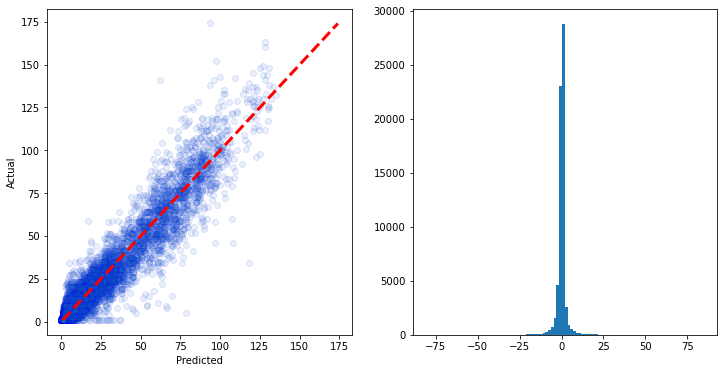

The model performance for testing set
--------------------------------------
MAE is 1.439696516562907
MSE is 10.509775585307215
RMSE is 3.2418784038435517
R2 score is 0.9317171795361114
Max error is 84.43360137939453


[1.439696516562907, 0.9317171795361114]

In [29]:
model=build_reg_nn(layers=[64,32,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try Increasing the Network Width

Epoch 1/30
8280/8280 [==============================] - 9s 1ms/step - loss: 40.0153 - root_mean_squared_error: 6.3258
Epoch 2/30
8280/8280 [==============================] - 8s 938us/step - loss: 18.3048 - root_mean_squared_error: 4.2784
Epoch 3/30
8280/8280 [==============================] - 8s 939us/step - loss: 16.1472 - root_mean_squared_error: 4.0184
Epoch 4/30
8280/8280 [==============================] - 7s 847us/step - loss: 14.8929 - root_mean_squared_error: 3.8591
Epoch 5/30
8280/8280 [==============================] - 7s 877us/step - loss: 14.0960 - root_mean_squared_error: 3.7545
Epoch 6/30
8280/8280 [==============================] - 8s 986us/step - loss: 13.7061 - root_mean_squared_error: 3.7022
Epoch 7/30
8280/8280 [==============================] - 7s 852us/step - loss: 13.4393 - root_mean_squared_error: 3.6660
Epoch 8/30
8280/8280 [==============================] - 7s 877us/step - loss: 12.8800 - root_mean_squared_error: 3.5889
Epoch 9/30
8280/8280 [====================

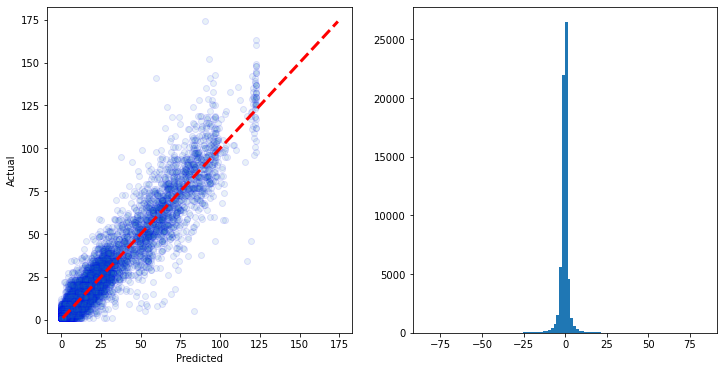

The model performance for testing set
--------------------------------------
MAE is 1.6554434357277625
MSE is 11.564931007449365
RMSE is 3.4007250708414176
R2 score is 0.9248617535884485
Max error is 83.45059204101562


[1.6554434357277625, 0.9248617535884485]

In [30]:
model=build_reg_nn(layers=[128,64],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Use Tanh Activation instead of ReLu

Epoch 1/30
8280/8280 [==============================] - 8s 946us/step - loss: 49.9892 - root_mean_squared_error: 7.0703
Epoch 2/30
8280/8280 [==============================] - 8s 908us/step - loss: 19.2823 - root_mean_squared_error: 4.3912
Epoch 3/30
8280/8280 [==============================] - 9s 1ms/step - loss: 16.3450 - root_mean_squared_error: 4.0429
Epoch 4/30
8280/8280 [==============================] - 8s 931us/step - loss: 15.1054 - root_mean_squared_error: 3.8866
Epoch 5/30
8280/8280 [==============================] - 7s 813us/step - loss: 14.3316 - root_mean_squared_error: 3.7857
Epoch 6/30
8280/8280 [==============================] - 6s 722us/step - loss: 13.6727 - root_mean_squared_error: 3.6977
Epoch 7/30
8280/8280 [==============================] - 6s 724us/step - loss: 13.1407 - root_mean_squared_error: 3.62500s - loss: 13.0254 - root_mean_squ
Epoch 8/30
8280/8280 [==============================] - 6s 723us/step - loss: 13.0724 - root_mean_squared_error: 3.6156
Epoch 9/

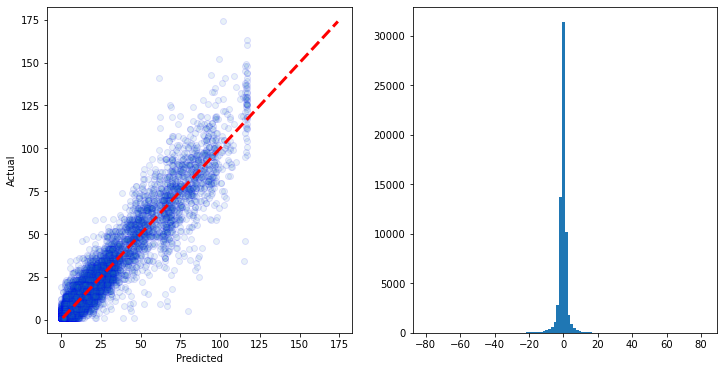

The model performance for testing set
--------------------------------------
MAE is 1.624883999493239
MSE is 11.84502894781544
RMSE is 3.4416607833741315
R2 score is 0.9230419357227787
Max error is 81.13716125488281


[1.624883999493239, 0.9230419357227787]

In [31]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Increase Epochs

Epoch 1/80
8280/8280 [==============================] - 7s 805us/step - loss: 32.5122 - root_mean_squared_error: 5.7019
Epoch 2/80
8280/8280 [==============================] - 7s 898us/step - loss: 17.9342 - root_mean_squared_error: 4.2349
Epoch 3/80
8280/8280 [==============================] - 8s 922us/step - loss: 16.2576 - root_mean_squared_error: 4.0321
Epoch 4/80
8280/8280 [==============================] - 7s 874us/step - loss: 14.8354 - root_mean_squared_error: 3.8517
Epoch 5/80
8280/8280 [==============================] - 7s 845us/step - loss: 13.9713 - root_mean_squared_error: 3.7378
Epoch 6/80
8280/8280 [==============================] - 7s 805us/step - loss: 13.1783 - root_mean_squared_error: 3.6302
Epoch 7/80
8280/8280 [==============================] - 7s 793us/step - loss: 12.5887 - root_mean_squared_error: 3.5481
Epoch 8/80
8280/8280 [==============================] - 6s 751us/step - loss: 12.4021 - root_mean_squared_error: 3.5217
Epoch 9/80
8280/8280 [==================

8280/8280 [==============================] - 6s 771us/step - loss: 9.1849 - root_mean_squared_error: 3.0307
Epoch 70/80
8280/8280 [==============================] - 6s 744us/step - loss: 9.1513 - root_mean_squared_error: 3.0251
Epoch 71/80
8280/8280 [==============================] - 6s 737us/step - loss: 9.1681 - root_mean_squared_error: 3.0279
Epoch 72/80
8280/8280 [==============================] - 6s 752us/step - loss: 9.1496 - root_mean_squared_error: 3.0248
Epoch 73/80
8280/8280 [==============================] - 6s 710us/step - loss: 9.0996 - root_mean_squared_error: 3.0165
Epoch 74/80
8280/8280 [==============================] - 6s 725us/step - loss: 9.1452 - root_mean_squared_error: 3.0241
Epoch 75/80
8280/8280 [==============================] - 6s 767us/step - loss: 9.1190 - root_mean_squared_error: 3.0198
Epoch 76/80
8280/8280 [==============================] - 7s 843us/step - loss: 8.9991 - root_mean_squared_error: 2.9999
Epoch 77/80
8280/8280 [=============================

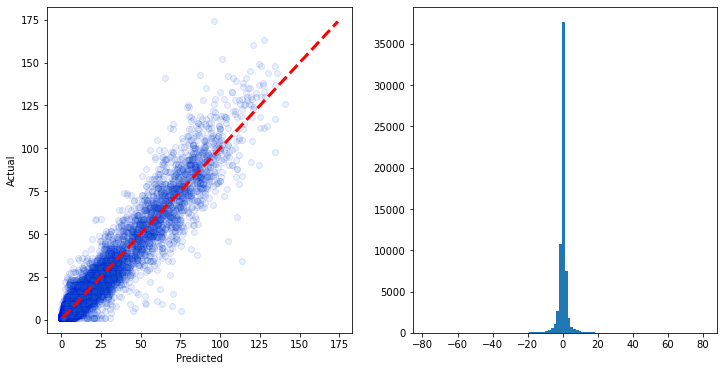

The model performance for testing set
--------------------------------------
MAE is 1.4290717717241737
MSE is 10.245742550426556
RMSE is 3.2008971477425754
R2 score is 0.9334326224750165
Max error is 80.00166320800781


[1.4290717717241737, 0.9334326224750165]

In [32]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="relu")
model.fit(X_train_s,y_train,batch_size=16,epochs=80)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

When doing even more epochs, training loss seems to decrease further. However, there is not much change in test set performance. This indicates that the network starts to remember entries - which is considered as overfitting.

## Variation of Temporal and Spatial Resolution
We find that a basic neural network with two hidden layers with 64 and 32 nodes is capable of delivering very good results, while changing model characteristics doesn't seem to bring significant performance benefits. We try this network architecture to build a model for all of our resolutions and assess their respective performances.

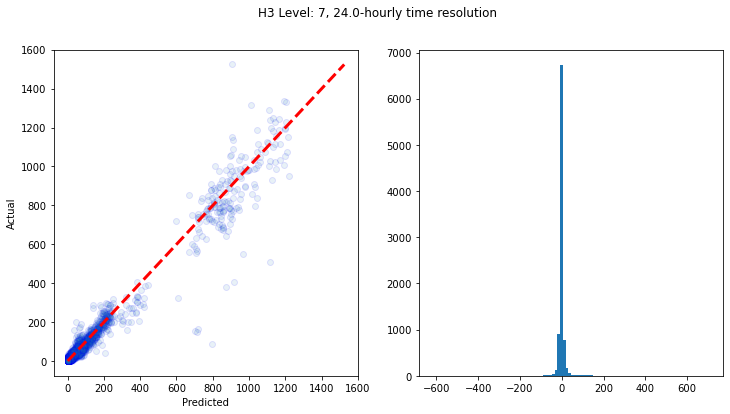

The model performance for testing set
--------------------------------------
MAE is 8.177252159266176
MSE is 682.2479685089155
RMSE is 26.11987688540885
R2 score is 0.9607740905188786
Max error is 706.172607421875


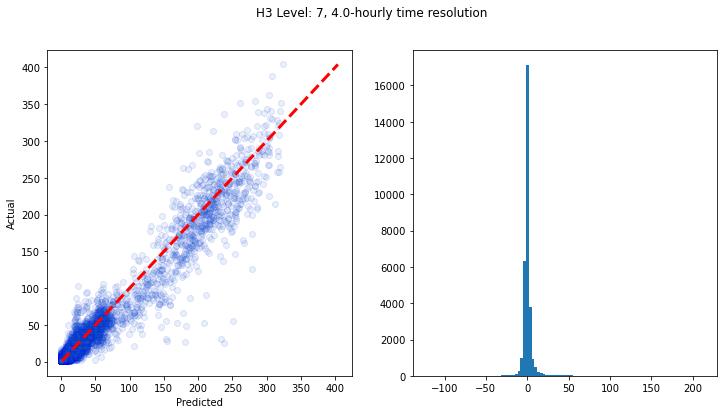

The model performance for testing set
--------------------------------------
MAE is 3.214559432448689
MSE is 60.84000827932602
RMSE is 7.800000530726009
R2 score is 0.9420570392013952
Max error is 212.4270477294922


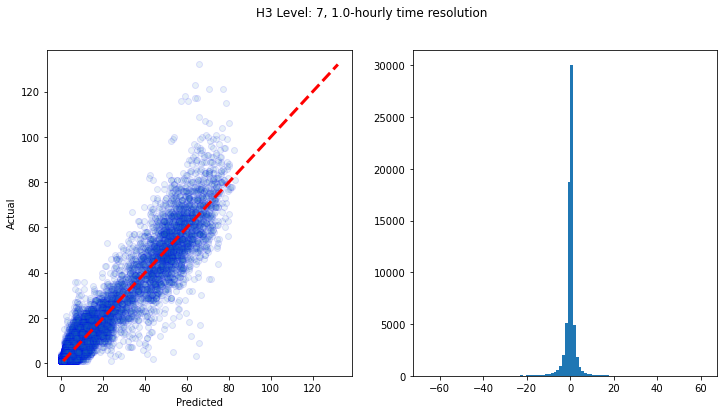

The model performance for testing set
--------------------------------------
MAE is 1.4708328913137725
MSE is 9.511947896865603
RMSE is 3.084144597269331
R2 score is 0.9211310582618306
Max error is 66.19226837158203


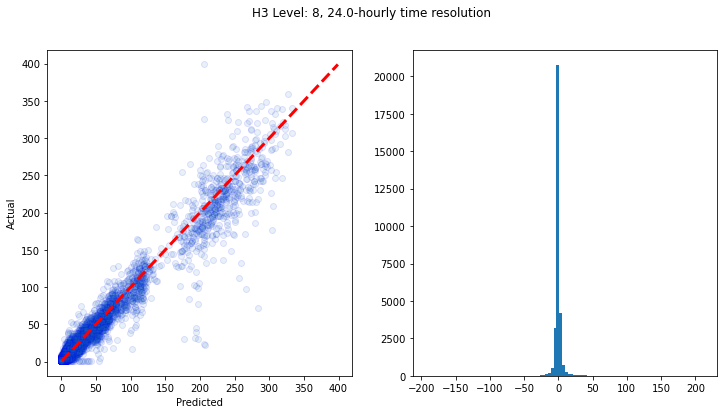

The model performance for testing set
--------------------------------------
MAE is 2.815233843264031
MSE is 49.66024280227127
RMSE is 7.047002398344367
R2 score is 0.9544606729140873
Max error is 211.17727661132812


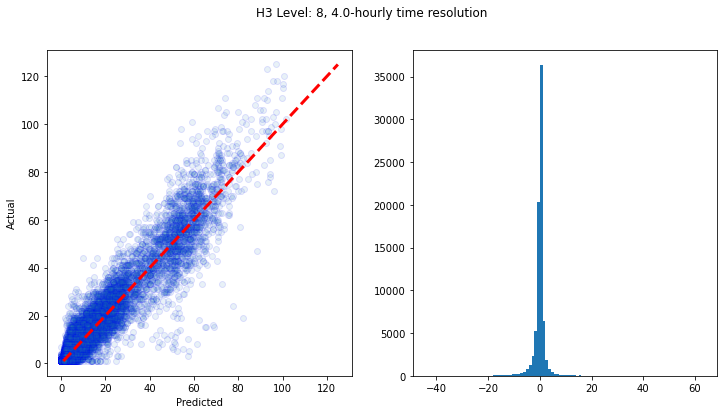

The model performance for testing set
--------------------------------------
MAE is 1.2915596874790223
MSE is 7.360718782157623
RMSE is 2.71306446332512
R2 score is 0.9170378385633933
Max error is 63.099403381347656


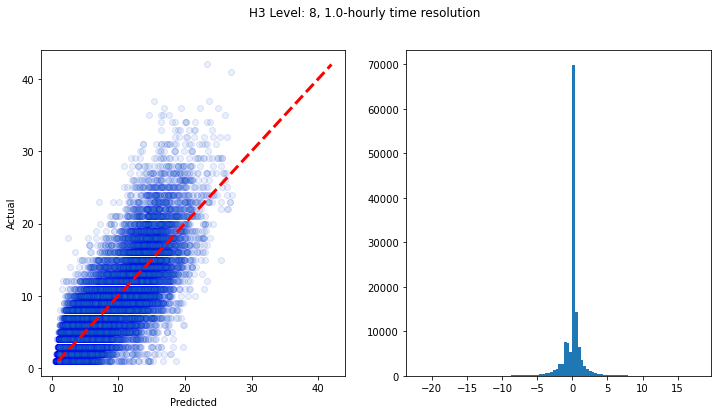

The model performance for testing set
--------------------------------------
MAE is 0.7912683535146054
MSE is 2.365065708374094
RMSE is 1.5378770134097506
R2 score is 0.8029306086812985
Max error is 21.69061279296875


In [33]:
spatial_resolutions = [7,8]
temporal_resolutions = [1,6,24]

for spatial_resolution in spatial_resolutions:
    for temporal_resolution in temporal_resolutions:
        df_pred_loop = get_data(df,
                                weather_df,
                                df_poi,
                                temporal_resolution,
                                spatial_resolution,
                                dummy_poi_category=True,
                                dummy_weather=False,
                                dummy_h3=True)
        
                #Split off dependant and independant variable
        y=df_pred_loop["count"]
        X=df_pred_loop.drop(columns="count")

        #Train Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        #Scaling
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],))
        model.fit(X_train_s,y_train,batch_size=16,epochs=30,verbose=0) #suppresses progress bar

        y_pred=model.predict(X_test_s)
        y_pred=y_pred.reshape(y_pred.shape[0],)
        
        title="H3 Level: " + str(spatial_resolution) + ", "+str(24/temporal_resolution)+"-hourly time resolution"
        eval_reg(y_test,y_pred,title)

This architecture seems to work fine for almost all cases, however, for the hourly data evaluatoin metrics are slighlty off. This motivates us to run a grid search for particularly for hourly data.

# Grid Search with NN

In [34]:
# helper function to get different number of layers and nodes in the grid search.
# note we can have no less than 2 layers.
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    # initialize empty vector
    layers = []
    
    # get node difference between every layer depending on nodes in first and last layer.
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    # nodes of first lay as defined in the function call.
    nodes = first_layer_nodes
    # add node increment to every following layer.
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

# function to build neural network with adjustable depth, width, dropout, regularization, activatoin, loss and optimizer.
def build_reg_nn(n_layers, first_layer_nodes, last_layer_nodes, dropout_rate, penalty_rate, activation_func, loss_func, optimizer_func):
    # initialize model
    model = Sequential()
    # get number of nodes for every layer with helper funciton
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    # creating all layers
    for i in range(0, n_layers):
        # create first layer.
        if i==0:
            model.add(Dense(first_layer_nodes, kernel_regularizer = regularizers.l2(penalty_rate), activation=activation_func, input_dim=X_train_s.shape[1]))
            model.add(Dropout(dropout_rate))
        # add consecutive layers.
        else:
            model.add(Dense(n_nodes[i],kernel_regularizer = regularizers.l2(penalty_rate), activation=activation_func))
            model.add(Dropout(dropout_rate))
    #Finally, output layer with single node for continous variable
    model.add(Dense(1, activation=activation_func))
    # compile model with root mean squared error as metric
    model.compile(loss=loss_func,
                  optimizer=optimizer_func,
                  metrics = [metrics.RootMeanSquaredError()])
    
    return model

In [36]:
# create grid parameters

dropout_rates = [#0.0,
                 0.1
                # 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 # large scale grid search
                ]

penalty_rates =[#0.0, 0.1
                0.01
                #, 0.001 # large scale grid search
               ]

batch_sizes = [16
              # 20, 40, 80, 100 # large scale grid search
              ]

epoch_sizes = [# 10, 
                20
               # 30, 50, 100 # large scale grid search
               ]


activation_funcs = ['relu'] 
loss_funcs = ['mse']
optimizer_funcs = ['adam'
                   # 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam' # large scale grid search
                  ]

param_grid = dict(n_layers=[2,3],
                  first_layer_nodes = [64,128],
                  last_layer_nodes = [32],
                  dropout_rate = dropout_rates,
                  penalty_rate = penalty_rates,
                  activation_func = activation_funcs,
                  loss_func = loss_funcs,
                  optimizer_func = optimizer_funcs,
                  batch_size = batch_sizes, 
                  epochs = epoch_sizes) 
param_grid

{'n_layers': [2, 3],
 'first_layer_nodes': [64, 128],
 'last_layer_nodes': [32],
 'dropout_rate': [0.1],
 'penalty_rate': [0.01],
 'activation_func': ['relu'],
 'loss_func': ['mse'],
 'optimizer_func': ['adam'],
 'batch_size': [16],
 'epochs': [20]}

Best: -3.352774 using {'activation_func': 'relu', 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 20, 'first_layer_nodes': 128, 'last_layer_nodes': 32, 'loss_func': 'mse', 'n_layers': 3, 'optimizer_func': 'adam', 'penalty_rate': 0.01}


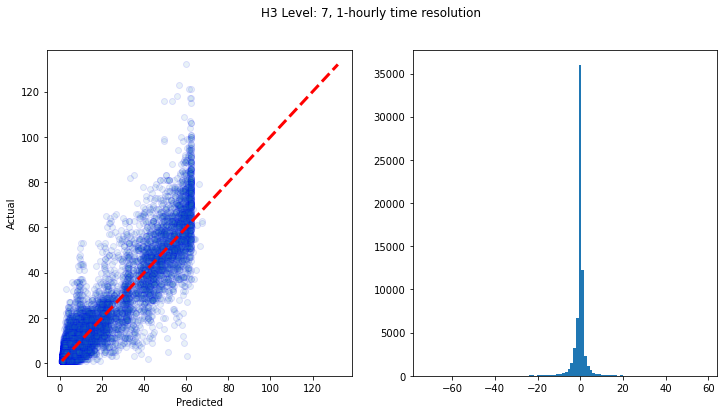

The model performance for testing set
--------------------------------------
MAE is 1.5870433948793645
MSE is 13.203926075473817
RMSE is 3.6337206931014685
R2 score is 0.8905187783140824
Max error is 72.05645751953125
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               25216     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 80)                10320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2592      
_________________________________

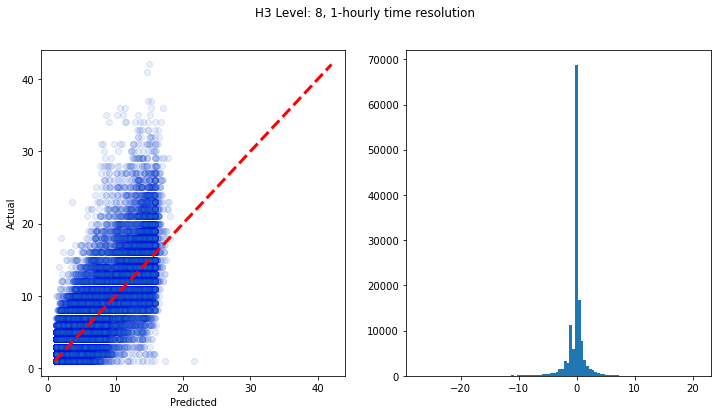

The model performance for testing set
--------------------------------------
MAE is 0.8665720614710323
MSE is 3.0333921054847357
RMSE is 1.7416636028477874
R2 score is 0.7472422293629247
Max error is 26.978851318359375
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 64)                58624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 60,737
Trainable p

In [39]:
spatial_resolutions = [7,8]
temporal_resolution = 24

for spatial_resolution in spatial_resolutions:
    df_pred = get_data(df,
                            weather_df,
                            df_poi,
                            temporal_resolution,
                            spatial_resolution,
                            dummy_poi_category=True,
                            dummy_weather=False,
                            dummy_h3=True)

    #Split off dependent and independent variable
    y=df_pred["count"]
    X=df_pred.drop(columns="count")

    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #Scaling
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    model_nn = KerasRegressor(build_fn= build_reg_nn, verbose=0)
    grid = GridSearchCV(estimator = model_nn, param_grid = param_grid, n_jobs=-1, cv=5, scoring = 'neg_root_mean_squared_error')
    grid_result = grid.fit(X_train_s, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_y_pred = grid.best_estimator_.model.predict(X_test_s)
    y_pred=best_y_pred.reshape(best_y_pred.shape[0],)

    title="H3 Level: " + str(spatial_resolution) + ", "+str(round(24/temporal_resolution))+"-hourly time resolution"
    eval_reg(y_test,y_pred,title)
    grid.best_estimator_.model.summary()

_____________________________________________________________

## 4. SVM

Now we proceed to model the relationship of the predictors with the demand using an SVR. We start with a simple model using no kernel. We then compare this against a model with kernel and improve our best model using a gridsearch over a predefined space of hyperparameters. We conclude this section by comparing the performance of the model over a variety of temporal and spacial resolutions.

For each model visualization and performance measures are beeing compared.

### 4.1.1 and 4.1.2. SVM Prediction and Evaluation

In [40]:
df_pred_svr = df_pred_ann

In [41]:
df_pred_svr.shape

(197715, 916)

As pointed out by the sklearn library, fit time complexity is more than quadratic with the number of samples using Sklearn's SVR, which makes it hard to scale to datasets with more than a couple of 10000 samples. Therefore, we sample a subset of our actual dataset to approximate the characteristics of our whole dataset

In [42]:
df_pred_svr = df_pred_svr.sample(n=5000) 

In [43]:
#Split off dependent and independent variable
y = df_pred_svr["count"]
X = df_pred_svr.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

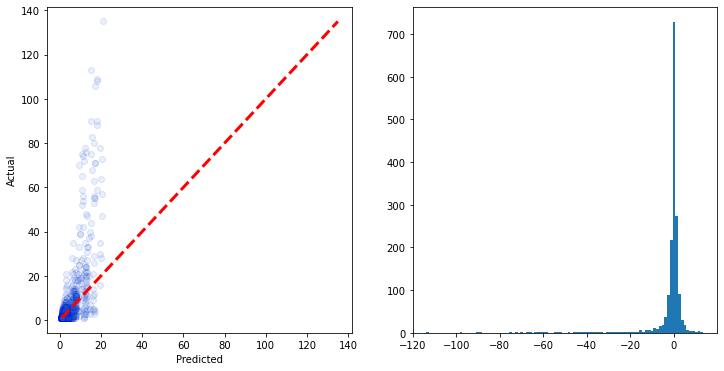

The model performance for testing set
--------------------------------------
MAE is 3.061054656704434
MSE is 98.70331125545975
RMSE is 9.93495401375667
R2 score is 0.32368231899924216
Max error is 113.82936949286376


[3.061054656704434, 0.32368231899924216]

In [44]:
#Start without a Kernel
model_svr = SVR()
model_svr.fit(X_train_s,y_train)
y_pred = model_svr.predict(X_test_s)

eval_reg(y_test,y_pred)

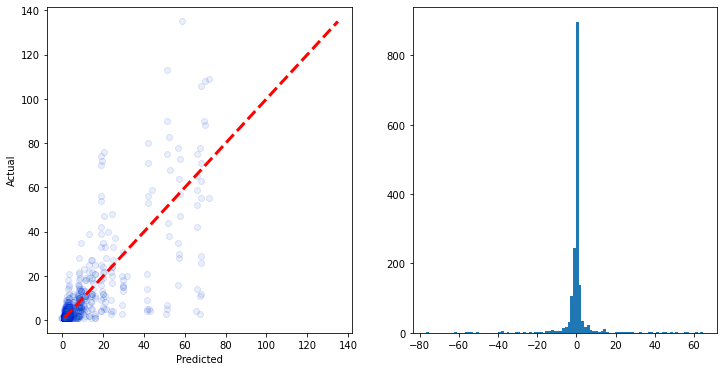

The model performance for testing set
--------------------------------------
MAE is 2.696768610088832
MSE is 57.72660816026222
RMSE is 7.59780285084196
R2 score is 0.604455764792507
Max error is 76.52061752675608


[2.696768610088832, 0.604455764792507]

In [45]:
#Make more complex
model_svr2 = SVR(kernel='linear')
model_svr2.fit(X_train_s,y_train)
y_pred = model_svr2.predict(X_test_s)

eval_reg(y_test,y_pred)

As we can see, our model performs better with a linear kernel than with none (or RBF kernel, since that is used as default in Sklearn). This would suggest that our data is linearly separable based on the relatively large number of features.

#### Tune Hyperparameters

For tweaking the hyperparameters we are going to take a closer look at the Linear and Polynomial kernels. Other possibilities are 'sigmoid' and 'precomputed', which we will not include in the grid search due to memory restrictions. Further parameters are **C**: Regularization parameter, **Degree**: It is the degree of the polynomial kernel function ('poly') and **Gamma**: The kernel coefficient for 'rbf', 'poly', and 'sigmoid'.

In [46]:
#Tune Hyperparams
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1,1,10],'kernel':['linear']} #loop through predefined number of hyperparameters

grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train_s,y_train)

print(grid.best_params_)
print(grid.score(X_test_s,y_test))

{'C': 0.1, 'kernel': 'linear'}
0.61082527152828


Now we run our svr model with optimized hyperparameters based on the result of the gridsearch:

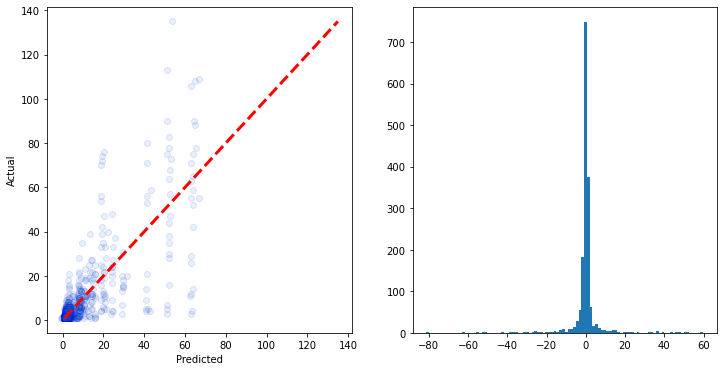

The model performance for testing set
--------------------------------------
MAE is 2.689710163036293
MSE is 56.79702813663416
RMSE is 7.536380307324874
R2 score is 0.61082527152828
Max error is 81.24700387704237


[2.689710163036293, 0.61082527152828]

In [48]:
#Run Model with tuned hyperparams
model_svr3 = SVR(kernel='linear', C=0.1)
model_svr3.fit(X_train_s,y_train)
y_pred = model_svr3.predict(X_test_s)

eval_reg(y_test,y_pred)

### 4.1.3 Variation of Temporal and Spatial Resolution

In this section, we aim to explore the performance of our best model based on a variation of termporal and spatial resolutions.

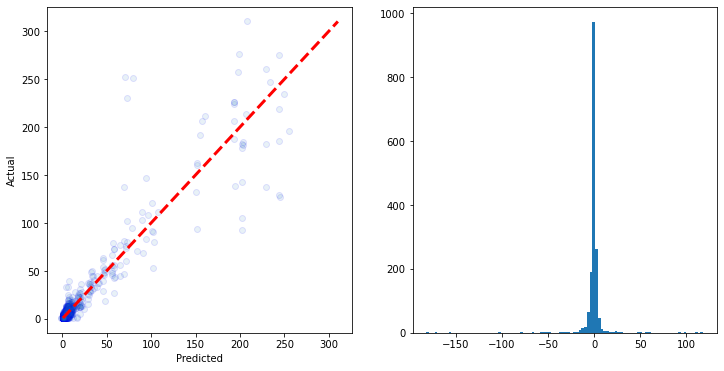

The model performance for testing set
--------------------------------------
MAE is 3.4315646550474286
MSE is 141.11901871287634
RMSE is 11.879352621791995
R2 score is 0.8644167040815225
Max error is 181.78658203494314


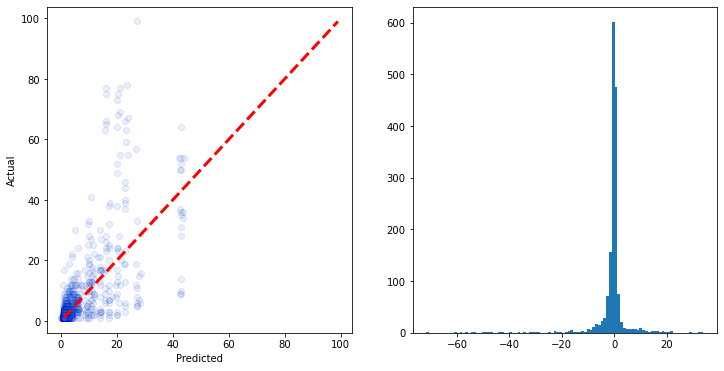

The model performance for testing set
--------------------------------------
MAE is 2.496180256051056
MSE is 48.15195781822262
RMSE is 6.939161175403164
R2 score is 0.49748971540854736
Max error is 71.6656282457817


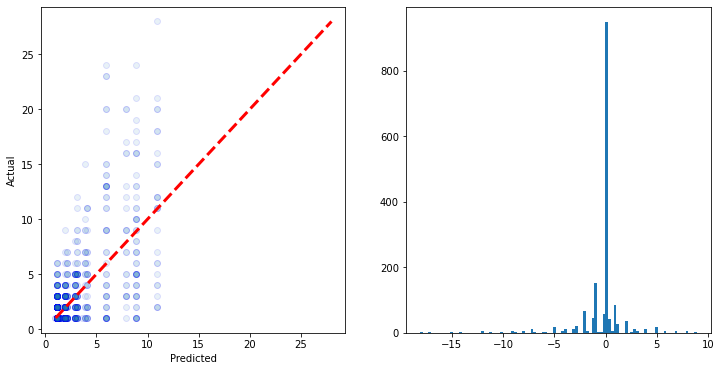

The model performance for testing set
--------------------------------------
MAE is 0.9985909827601284
MSE is 4.980786813818468
RMSE is 2.231767643330835
R2 score is 0.4871612835013659
Max error is 18.099986321824517


In [49]:
#generate datasets - temporal dimension (slice per day, e.g., 4 beeing 4 slices, so 6 hour intervalls)
tempres_level = [1, 6, 24]
results=[]
for element in tempres_level:
    #shape new dataframe and repeat the usual process
    df_pred_svr = get_data(df,weather_df,df_poi,element,8,dummy_poi_category=True,dummy_weather=False,dummy_h3=True)
    if len(df_pred_svr) > 5000:
        df_pred_svr = df_pred_svr.sample(n=5000) 
    
    y=df_pred_svr["count"]
    X=df_pred_svr.drop(columns="count")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    
    #train and evaluate on new dataframe
    model = SVR(kernel='linear')
    model.fit(X_train_s,y_train)
    y_pred = model.predict(X_test_s)

    results.append((eval_reg(y_test,y_pred)) + [element])



In [50]:
end = timer()
print()
print("Total Notebook Runtime (s): ", end - start)


Total Notebook Runtime (s):  9340.5819347


As you can observe, the prediction of demand is much more difficult for smaller time intervals, than for larger ones, such as from a whole day.